# Please download those .pkl files in "check PL/HDPGMM model" folder on Google drive 

In [1]:
import time 
import sys
from blu import *  
from marginal_plt import *
%matplotlib inline
math_blu = '$\mathcal{B}_{\mathcal{H}_{\mathrm{U}}}^{\mathcal{H}_{\mathrm{L}}}$'

# posterior samples 
with open('./posterior/img1_det_m1qxeff.pkl', 'rb') as f:
    img1=dill.load(f)
with open('./posterior/img2_det_m1qxeff.pkl', 'rb') as f:
    img2=dill.load(f)
# benchmark model
with open('./pop_prior/benchmark_dist.pkl', 'rb') as f:
    pop_true=dill.load(f)
    
with open('./pop_prior/wrong_model_draws_norm.pkl', 'rb') as f:
    pop_plm=dill.load(f)
np.random.seed(0)
p = np.random.permutation(len(pop_plm)) # shuffle the model

pop_plm=np.array(pop_plm)[p]

# paramteric form    
mmin = 15.15
mmax = 225.4

sqrt2pi = np.sqrt(2*np.pi)

def pl_mass(x, a, xmin, xmax):
    return x**-a * (1-a)/(xmax**(1-a) - xmin**(1-a))
    
def pl_q(x, a):
    xx = x**-a * (1-a)
    return x**-a * (1-a)


def gaussian(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sqrt2pi*sigma)

def par_model(s, a, b, mu, sigma):
    return pl_mass(s[:,0], a, mmin, mmax)*pl_q(s[:,1], b)*gaussian(s[:,2], mu, sigma)

# only compute the blu within the reliable region of reconstructed astro population function
data=np.load('../Mock_data/catalog/m1m2zxeff_posterior_138_lensed.npz')
m1,m2,redshift,xeff = data['m1'],data['m2'],data['redshift'], data['xeff'] 
q= m2/m1
m1z = m1*(1+redshift)
m1z = m1z[:int(m1z.size/2)]
q = q[:int(q.size/2)]
n = m1z.size
index = np.where((m1z<90)*(q>0.35))[0]

# we can also compute the another reference for m1z, q by using the mean of posterior samples
m1zref = np.zeros(m1z.size)
qref = np.zeros(q.size)
for i in index[:n]:
    m1zref[i] = (np.array(img1)[i].rvs(5000)[:,0].mean() + np.array(img2)[i].rvs(5000)[:,0].mean() ) /2 
    qref[i] = (np.array(img1)[i].rvs(5000)[:,1].mean() + np.array(img2)[i].rvs(5000)[:,1].mean() ) /2 
    


BLU-lensed pair: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:27<00:00,  1.51s/it]


Nmodel= 50


dist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.22it/s]


(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='$m_1^z [M_{\\odot}]$', ylabel='$\\mathcal{B}_{\\mathcal{H}_{\\mathrm{U}}}^{\\mathcal{H}_{\\mathrm{L}}}$'>)

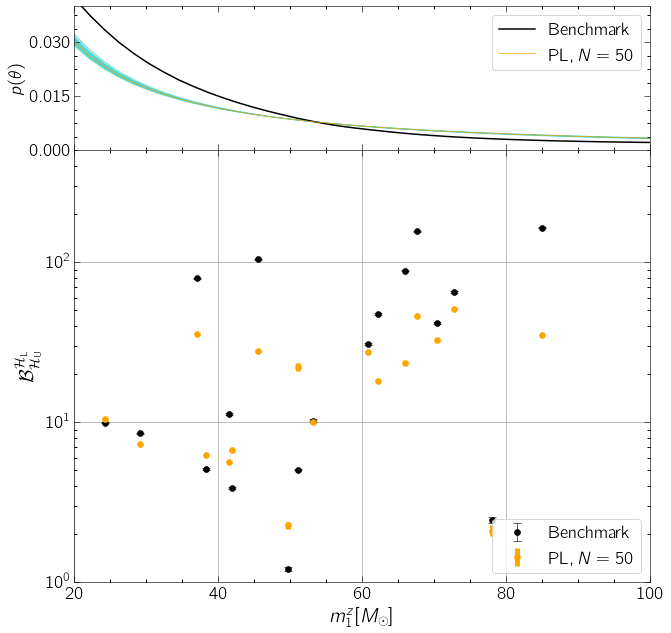

In [2]:

Nmodel = 50
pop_pl=pop_plm[:Nmodel]

N = 2e4
OLU_pl = OddsRatio(gw_pop=pop_pl,Nmc=N)
OLU_true = OddsRatio(gw_pop=pop_true,Nmc=N)

blu_true=np.zeros((n,2))
blu_pl=np.zeros((n,2))
for i in tqdm(index[:n], total = int(index[:n].size), desc = 'BLU-lensed pair'):
    blu_true[i]=OLU_true.BayesFactor_PEuniform(img1[i],img2[i])
    blu_pl[i]=OLU_pl.BayesFactor_PEuniform(img1[i],img2[i])


ylim=(1e0,5e2)
xlim=[20,100]

## Plot using the true m1z 
#plotting_two(m1z[index],blu_true[index], blu_pl[index],pop_pl, pop_true, color='orange', label=r'$\mathrm{PL}'+',N={:d}$'.format(len(pop_pl)),
#             ylabel=math_blu,xlim=xlim,ylim=ylim,yscale='log')

# Plot using the m1z posterior mean for m1z-coordinate 
plotting_two(m1z[index],blu_true[index], blu_pl[index],pop_pl, pop_true, color='orange', label=r'$\mathrm{PL}'+',N={:d}$'.format(len(pop_pl)),
             ylabel=math_blu,xlim=xlim,ylim=ylim,yscale='log')

#plt.savefig('check_plt/blu_pl_'+str(len(pop_pl))+'_norm.pdf',bbox_inches = 'tight')

In [3]:
def plot_qaxis(x,y, model, true_model, color, flabel, label, 
                  ylabel, xlim=None, ylim=None, yscale='log',ticks = [0.2,0.4,0.6,0.8,1.0]):
    
    fig, axes = plt.subplots(nrows=2, sharex=True,
                             figsize=(8,8),gridspec_kw={'height_ratios': [1, 3]})
    fig.subplots_adjust(0,0,1,1,0,0)
    axes[1].scatter(x,y,label=flabel,color=color)
    marginal_plot(1,axes[0], model, 3, true_model, label=label, color=color, xlim=xlim,ticks=ticks)
    
    ax = axes[1]
    ax.set_ylabel(r''+ylabel,fontsize=20)
    ax.set_xlabel(r'$q$',fontsize=20)
    ax.xaxis.set_minor_locator(MultipleLocator(5)) 
    ax.set_xticks(ticks)
    #ax.set_xlim(xlim[0],xlim[1])
    plt.yscale('log')
    #ax.set_ylim(1e0,2e2)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(loc=4,fontsize=18)
    return fig, ax

def marginal_plot(column,ax, draws, dim, sample_dist = None, label = None, color = 'blue', 
                  figsize = 7, levels = [0.5, 0.68, 0.9], n_pts  = np.array([100,100,70]), 
                  xlim = None,ticks = [0.2,0.4,0.6,0.8,1.0]):

    if label is None:
        label = ['$x_{0}$'.format(i+1) for i in range(dim)]

        
    levels = np.atleast_1d(levels)
    z_bds  = [0.2,1.3]
    mlim = [15*(1+z_bds[0]), 98*(1+z_bds[1])]
    if xlim is None:
        xlim = mlim
    ####### grid ######
    q_bds  = [0.2, 1.]
    q  = np.linspace(q_bds[0], q_bds[1], n_pts[1]+2)[1:-1]
    m = np.linspace(mlim[0], mlim[1], n_pts[0]+2)[1:-1]
    dm = m[1]-m[0]
    chieff = np.linspace(-1.,1., n_pts[2]+2)[1:-1]
    dgrid = [m[1]-m[0], q[1]-q[0], chieff[1]-chieff[0]]
    dims = list(np.arange(dim, dtype = int))
    dims.remove(column)
    grid  = np.zeros(shape = (np.prod(n_pts), 3))

    for i, m1i in enumerate(m):
        for j, qi in enumerate(q):
                for l, xi in enumerate(chieff):
                    grid[i*(n_pts[1]*n_pts[2]) + j*n_pts[2] + l] = [m1i, qi, xi]
    ################
    #Benchmark plot                
    probs = sample_dist(grid).reshape(n_pts)
    probs = np.array([probs.sum(axis = tuple(dims))*np.prod([dgrid[k] for k in dims])]).reshape(m.shape)
    norm = probs.sum()*dgrid[1]
    ax.plot(q, probs/norm, lw = 1.5, color='black', label=r'$\mathrm{Benchmark}$')
    # inferred models
    if np.iterable(draws): 
        ###### grid
        np.array([75,75,70])
        q  = np.linspace(q_bds[0], q_bds[1], n_pts[1]+2)[1:-1]
        m = np.linspace(mlim[0], mlim[1], n_pts[0]+2)[1:-1]
        dm = m[1]-m[0]
        dq = q[1]-q[0]
        chieff = np.linspace(-1.,1., n_pts[2]+2)[1:-1]
        dgrid = [m[1]-m[0], q[1]-q[0], chieff[1]-chieff[0]]
        grid  = np.zeros(shape = (np.prod(n_pts), 3))

        for i, m1i in enumerate(m):
            for j, qi in enumerate(q):
                    for l, xi in enumerate(chieff):
                        grid[i*(n_pts[1]*n_pts[2]) + j*n_pts[2] + l] = [m1i, qi, xi]

        
        astro_dists = np.array([(d.pdf(grid).reshape(n_pts)) for d in tqdm(draws, total = len(draws), desc = 'dist')])
        probs = np.array([m.sum(axis = tuple(dims))*np.prod([dgrid[k] for k in dims]) for m in astro_dists])
        # Credible regions
        percentiles = [50, 5, 16, 84, 95]
        p = {}
        for perc in percentiles:
            p[perc] = np.percentile(probs, perc, axis = 0)

        norm = p[50].sum()*dgrid[column]
        for perc in percentiles:
            p[perc] = p[perc]/norm
        # CR
        ax.fill_between(q, p[95], p[5], color = 'mediumturquoise', alpha = 0.5)
        ax.fill_between(q, p[84], p[16], color = 'darkturquoise', alpha = 0.5)
        ax.plot(q, p[50], lw = 0.7, color = color, label=label)
    else:
        # Uniform distribution
        probs = np.ones(n_pts[0]) 
        norm = (q[-1]-q[0])
        ax.plot(q, probs/norm, lw = 1.5, color=color, label=label)
        
    ax.set_ylim(0,2.4)
    ax.set_yticks([])
    ax.yaxis.set_major_locator(MaxNLocator(3)) 
    ax.set_ylabel(r'$p(\theta)$',fontsize=18)
    [l.set_rotation(45) for l in ax.get_xticklabels()]
    #ax.set_xlim(xlim[0],xlim[1])
    ax.xaxis.set_minor_locator(MultipleLocator(5)) 
    ax.set_xticks(ticks)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=18)

dist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.15it/s]


(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='$q$', ylabel='$\\Delta$$\\mathcal{B}_{\\mathcal{H}_{\\mathrm{U}}}^{\\mathcal{H}_{\\mathrm{L}}}$'>)

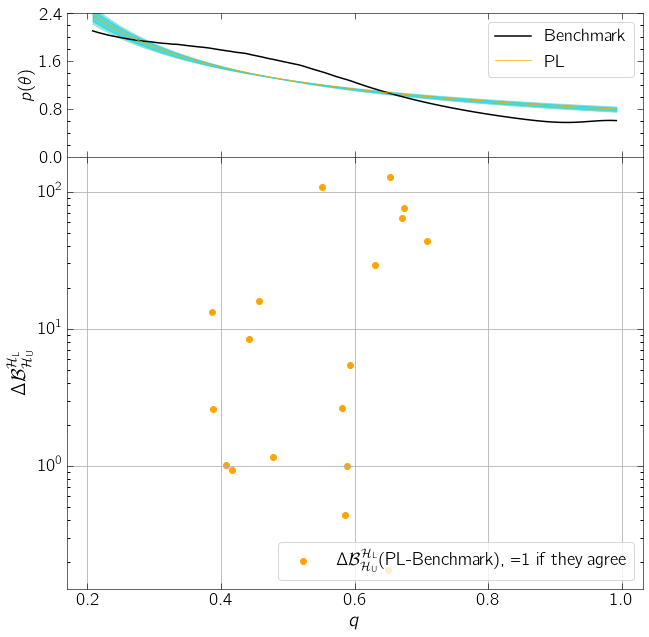

In [4]:
## calculate the difference between BLU base on the inferred model and benchmark value
x = abs(blu_pl[index][:,0] - blu_true[index][:,0])
x = x-blu_pl[index][:,1] # if the absolute diff. is larger than the errorbar, that means BLU(inferred model) doesnt agree with benchmark value
x[x<0] = 1 # if benchmark value ares within model based BLU (with error bar), assign it to be 1 since we are in log scale
flabel =r'$\Delta$'+ math_blu+'(PL-Benchmark), =1 if they agree'

# Plot using the true q
#plot_qaxis(q[index],x, pop_pl, pop_true, color='orange', flabel=flabel, label=r'$\mathrm{PL}$', ylabel=r'$\Delta$' + math_blu)
# Plot using the q posterior mean for q-coordinate 
plot_qaxis(qref[index],x, pop_pl, pop_true, color='orange', flabel=flabel, label=r'$\mathrm{PL}$', ylabel=r'$\Delta$' + math_blu)
